In [1]:
import numpy as np
import pandas as pd
np.random.seed(100)

import matplotlib.pyplot as plt
import pysensors as ps

In [2]:
from data_generation import *
from data_tranformation import *
from plotting import *
from state_concatenation import *

# Sensor Placement

In [3]:
def get_sliding_intervals(n_timesteps, window, step):
    """
    Return a list of (start, end) pairs for sliding windows.
      - n_timesteps: total number of time steps (e.g. 100)
      - window:      length of each window     (e.g. 20)
      - step:        shift between windows     (e.g. 5)
    """
    intervals = []
    end = window
    while end <= n_timesteps:
        start = end - window
        intervals.append((start, end))
        end += step
    return intervals

In [4]:
def get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=False):
    """
    Given a batch of fluid flow data for a time interval, 
    use PySensors to find optimal sensor locations.
    
    Parameters:
        data_interval : (n_timesteps, nx, ny) for the interval.
        n_sensors : number of sensors to select.
    
    Returns:
        sensor_coords, error (error of reconstruction on same data)
    """
    # axis=0: means do it col-wise (grid-point-wise); axis=1: means do it row-wise (time-step-wise)
    X = X - X.mean(axis=0)
    basis = ps.basis.SVD(n_basis_modes=n_basis_modes, complex_mode=is_data_complex, algorithm='arpack', random_state=90)
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)

    # Test the reconstruction error on the same data X.
    error = model.score(X)
    
    sensor_indices = model.selected_sensors # gets ranked sensors
    return sensor_indices, error


In [5]:
# Generate data
n_timesteps = 120      # Total number of timesteps in the dataset
n_sensors = 10         # Number of sensors to select in each interval
interval_length = 60   # Number of timesteps per batch
n_basis_modes = 10     # Number of modes in data

nx, ny = 30, 15 # number of grid points along each axis
lx, ly = 2, 1 # Fixed
period = 300
u_field, v_field = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny, lx=lx, ly=ly,
    A=0.1, epsilon=0.5, period=period
)

# nx, ny = 25, 25 # number of grid points along each axis
# lx, ly = 1, 1 # changeable
# period = 100
# u_field, v_field = generate_moving_vortex(n_timesteps, nx, ny, lx, ly, period=period)

In [6]:
magnitude = np.sqrt(u_field ** 2 + v_field ** 2)
magnitude = magnitude / magnitude.max()
angle = np.arctan2(v_field, u_field) 
angle = angle / angle.max()

In [7]:
# Feild representation
feild_representation = "complex" # ("complex", "concatenation")

if feild_representation == "concatenation":
    horizontal_concat = False
    data = combine_fields(u_field, v_field, horizontal_concat=horizontal_concat)
elif feild_representation == "complex":
    data = to_complex_cartesian(u_field, v_field) # (to_complex_cartesian, to_complex_polar)

_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

In [8]:
# Interval Params
sliding_intervals = True    # Boolean flag for sliding intervals
window_length, step_size = interval_length, 5    # Params for sliding window

if sliding_intervals:
    intervals = get_sliding_intervals(n_timesteps, window_length, step_size)
else:
    intervals = [
        (start, min(start + interval_length, n_timesteps))
        for start in range(0, n_timesteps, interval_length)
    ]

sensor_coords_list = []
for i, (start, end) in enumerate(intervals):
    data_interval = data[start:end]

    # flattens row-wise (but rmr row is a col-strip in our 2d map), so append on the slices of y-axis together
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    sensor_indices, _ = get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=(feild_representation == "complex"))
    
    # Convert the flat indices back to 2D coordinates on the nx x ny grid.
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx_t, ny_t))).T # get index in row-major form by default
    sensor_coords_list.append(sensor_coords)
    


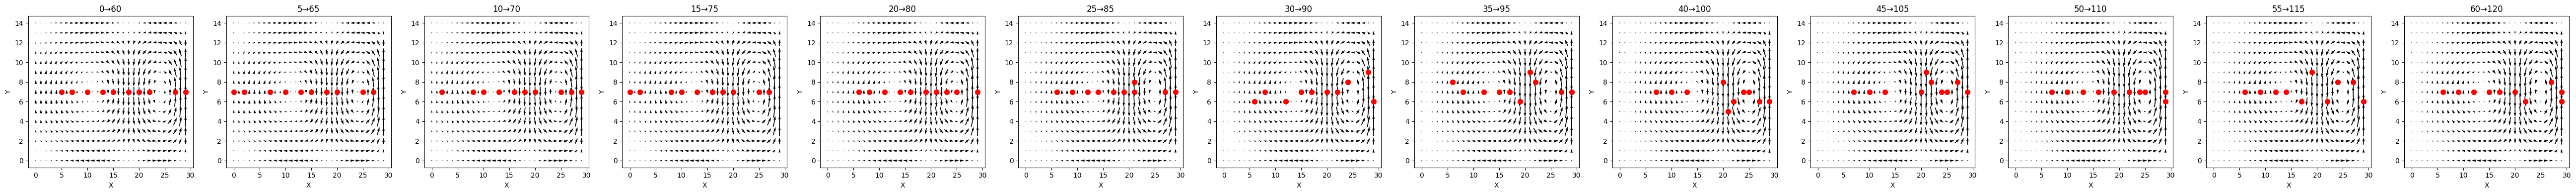

In [9]:
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)

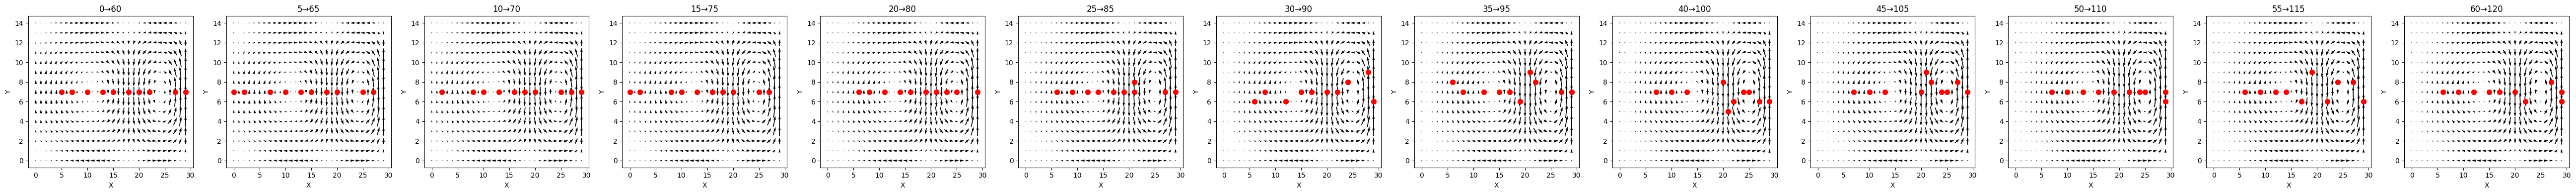

In [10]:
if feild_representation == "concatenation":
    sensor_coords_list = [map_sensor_to_original(sensor_coords, (nx_t, ny_t), horizontal_concat) for sensor_coords in sensor_coords_list]

plot_all_intervals((u_field, v_field), nx, ny, intervals, sensor_coords_list)

# Error Analysis

In [11]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

In [16]:
rows = []          # to build a DataFrame
horizontal_concat = True
data = combine_fields(u_field, v_field, horizontal_concat=horizontal_concat)
_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=True)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                complex_mode=True, algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_meas = X[:, sensor_idx]                
    X_pred = model.predict(Y_meas)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_state(X, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_state(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Cart",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


   interval representation  Cartesian RMSE  Polar RMSE
0      0-60    Concat-Cart        0.181775    0.881794
1      5-65    Concat-Cart        0.190845    1.227455
2     10-70    Concat-Cart        0.198406    1.156258
3     15-75    Concat-Cart        0.187744    1.094650
4     20-80    Concat-Cart        0.156072    0.989144
5     25-85    Concat-Cart        0.148040    1.155315
6     30-90    Concat-Cart        0.122154    0.516643
7     35-95    Concat-Cart        0.091930    0.661579
8    40-100    Concat-Cart        0.186791    1.318570
9    45-105    Concat-Cart        0.222230    1.316834
10   50-110    Concat-Cart        0.185673    1.105848
11   55-115    Concat-Cart        0.229804    1.360124
12   60-120    Concat-Cart        0.189580    0.908115


In [ ]:
rows   = []          # to build a DataFrame
horizontal_concat = True
data = combine_fields(magnitude, angle, horizontal_concat=horizontal_concat)

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=False)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                complex_mode=False, algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_meas = X[:, sensor_idx]                
    X_pred = model.predict(Y_meas)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_state(X,      nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_state(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Polar",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


   interval representation  Cartesian RMSE  Polar RMSE
0      0-60   Concat-Polar        0.627389    1.203860
1      5-65   Concat-Polar        0.627179    1.115377
2     10-70   Concat-Polar        0.607560    0.998913
3     15-75   Concat-Polar        0.469910    0.840327
4     20-80   Concat-Polar        0.760165    1.739335
5     25-85   Concat-Polar        0.536643    0.854469
6     30-90   Concat-Polar        0.320696    0.470043
7     35-95   Concat-Polar        0.542506    1.106779
8    40-100   Concat-Polar        0.665010    1.256914
9    45-105   Concat-Polar        0.246804    0.486781
10   50-110   Concat-Polar        0.664033    1.254952
11   55-115   Concat-Polar        0.535736    1.412184
12   60-120   Concat-Polar        0.567037    1.179478


# Sensor Flow Feild

In [ ]:
import cv2
import math
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

In [ ]:
def sensors_to_gaussian_img(coords, nx, ny, sigma=1.3, amp=1.0):
    """
    coords : array (n_sensors,2)  -- integer grid indices (i,j)
    nx, ny : grid dimensions
    sigma  : std‑dev of Gaussian (in pixels)
    returns: 2‑D float image of shape (nx, ny)
    """
    img = np.zeros((nx, ny), dtype=np.float32)
    for i, j in coords:
        img[i, j] = amp                          # delta spike
    if sigma > 0:
        img = gaussian_filter(img, sigma=sigma)  # blur into blob
    # normalize so max=1 (helps optical flow)
    img /= img.max() + 1e-9
    return img

In [ ]:
def get_farneback_hyperparams(nx, ny,        # grid resolution   (pixels)
                        lx, ly,        # domain size       (same units as velocity)
                        dt,            # time‑step between frames
                        u_max,         # estimate of max |u| in domain units/sec
                        blob_sigma_px, # Gaussian blur σ used for each sensor (pixels)
                        pyr_scale=0.5  # keep 0.5 
                       ):
    """
    Compute a reasonable Farnebäck parameter dictionary.
    Returns something you can splat straight into calcOpticalFlowFarneback(**params).
    """
    # convert physics to pixel displacements per frame 
    dx = lx / nx  # one pixel in physical units
    disp_px = u_max * dt / dx # max jump in *pixels* per frame

    # pick pyramid depth so residual motion <= 3 px at coarsest
    if disp_px <= 3:
        levels = 1
        residual = disp_px
    else:
        levels = math.ceil(1 + math.log(disp_px / 3, 1 / pyr_scale))
        residual = disp_px * (pyr_scale ** (levels - 1))

    # needs to cover both the blob diameter (≈ 4 σ) and the residual jump
    winsize = int(2 * max(blob_sigma_px * 2, residual))
    if winsize % 2 == 0: # Farnebäck prefers odd windows
        winsize += 1

    poly_n = 5 if max(nx, ny) < 1000 else 7
    poly_sigma = 1.1 if poly_n == 5 else 1.5

    return dict(pyr_scale=pyr_scale,
                levels=levels,
                winsize=winsize,
                iterations=3,  
                poly_n=poly_n,
                poly_sigma=poly_sigma,
                flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [ ]:
def compute_blob_sigma(sensor_coords_list,
                        target_amp=0.3,
                        mode="max"):
    """
    Compute blob σ so that across ALL timesteps your Gaussian blobs
    overlap at `target_amp` of peak.

    sensor_coords_list : list of (n_sensors,2) arrays or lists of (x,y) tuples
    target_amp         : desired amplitude at neighbor center (0<target_amp<1)
    mode               : "mean" (avg spacing) or "max" (worst-case spacing)
    """
    all_nn_dist = []

    for coords in sensor_coords_list:
        # ensure an (N,2) array of floats
        arr = np.array(coords, dtype=float)
        if arr.ndim != 2 or arr.shape[1] != 2:
            raise ValueError("Each coords entry must be shape (n,2)")

        # build KD-tree & find 2nd neighbor (first is self at zero)
        tree = cKDTree(arr)
        dists, _ = tree.query(arr, k=2)
        nn = dists[:,1] 
        all_nn_dist.append(nn)

    all_nn_dist = np.concatenate(all_nn_dist)

    if mode == "mean":
        d_ref = all_nn_dist.mean()
    elif mode == "max":
        d_ref = all_nn_dist.max()
    else:
        raise ValueError("mode must be 'mean' or 'max'")

    sigma_px = d_ref / math.sqrt(2 * math.log(1/target_amp))
    return sigma_px


In [ ]:
compute_blob_sigma(sensor_coords_list)

3.866588135745217

In [ ]:
# setting hyper_params
blob_sigma_px = compute_blob_sigma(sensor_coords_list)

frames = [sensors_to_gaussian_img(coord_set, nx, ny, sigma=blob_sigma_px)
          for coord_set in sensor_coords_list]   
frames = np.stack(frames, axis=0)

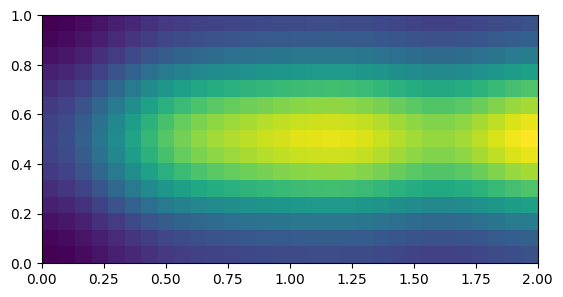

In [ ]:
plt.imshow(frames[0].T, origin='lower', extent=[0, lx, 0, ly], cmap='viridis')

In [ ]:
dt = period / n_timesteps
u_max = data.max()                    
fb_params = get_farneback_hyperparams(nx, ny, lx, ly, dt,
                                u_max, blob_sigma_px)

In [ ]:
flows = []  # will hold (flow_x, flow_y) arrays of shape (nx, ny)
for k in range(len(frames) - 1):
    f0 = frames[k].astype(np.float32)
    f1 = frames[k + 1].astype(np.float32)
    flow = cv2.calcOpticalFlowFarneback(
        prev=f0.T, next=f1.T,   # transpose: OpenCV uses (rows,cols) = (y,x)
        flow=None,
        **fb_params)
    # flow has shape (ny, nx, 2): (vx, vy) in pixel units
    flow = flow.transpose(1, 0, 2)   # back to (nx, ny, 2)
    flows.append(flow)

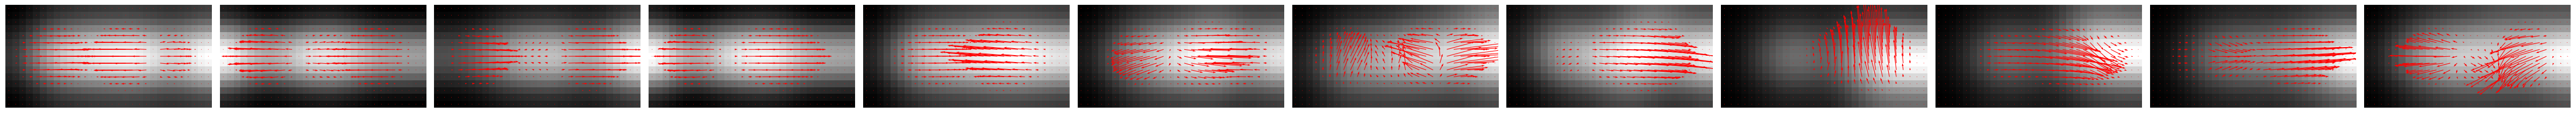

In [ ]:
fig, axes = plt.subplots(1, len(flows), figsize=(4*len(flows),4))
for ax, img, flow in zip(axes, frames[:-1], flows):
    ax.imshow(img.T, origin='lower', cmap='gray')
    skip = 1      # thin quiver for clarity
    X, Y = np.meshgrid(np.arange(0, nx, skip), np.arange(0, ny, skip), indexing='ij')
    U = flow[::skip, ::skip, 0];  V = flow[::skip, ::skip, 1]
    ax.quiver(X, Y, U, V, color='red')
    ax.set_axis_off()
plt.tight_layout(); plt.show()